# 实战Kaggle比赛：预测房价

实现几个函数来方便下载数据

第二和第七：autogluon
https://www.bilibili.com/video/BV1rh411m7Hb/

第三：H2O
https://www.kaggle.com/wuwawa/automl-using-h2o

第四：随机森林
https://www.kaggle.com/jackzh/the-4th-place-approach-random-forest

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):  
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

使用`pandas`读入并处理数据

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [3]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


前四个和最后两个特征，以及相应标签

In [4]:
# loc：通过行、列的名称或标签来索引
# iloc：通过行、列的索引位置来寻找数据
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


在每个样本中，第一个特征是ID，
我们将其从数据集中删除

In [5]:
# 删去ID部分，-1表示删除SalePrice部分
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

将所有缺失的值替换为相应特征的平均值。
通过将特征重新缩放到零均值和单位方差来标准化数据

In [6]:
# padas的object是python中的str!!!!!
# 找出数值特征
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 将数值特征减去平均值，除以方差
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

处理离散值。
我们用独热编码替换它们

In [7]:
# get_dummies 是利用pandas实现one hot encode的方式
df = pd.DataFrame([  
            ['green' , 'A'],   
            ['red'   , 'B'],   
            ['blue'  , 'A']])  

df.columns = ['color',  'class'] 
pd.get_dummies(df) 

,color_blue,color_green,color_red,class_A,class_B
0,False,True,False,True,False
1,False,False,True,False,True
2,True,False,False,True,False


In [8]:
s1 = ['a', 'b', np.nan]
pd.get_dummies(s1)

,a,b
0,True,False
1,False,True
2,False,False


In [9]:
pd.get_dummies(s1, dummy_na=True)

,a,b,NaN
0,True,False,False
1,False,True,False
2,False,False,True


In [10]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape
# 将True/False转化为1/0格式
all_features = all_features * 1

从`pandas`格式中提取NumPy格式，并将其转换为张量表示

In [11]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

训练

In [12]:
# 均方误差（Mean Squared Error, MSE）
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

我们更关心相对误差$\frac{y - \hat{y}}{y}$，
解决这个问题的一种方法是用价格预测的对数来衡量差异

In [13]:
def log_rmse(net, features, labels):
    # torch.clamp(input, min, max, out=None)
    # 将输入input张量每个元素的范围限制到区间 [min,max]，返回结果到一个新张量。
    # input (Tensor) – 输入张量
    # min (Number) – 限制范围下限
    # max (Number) – 限制范围上限
    # out (Tensor, optional) – 输出张量
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    # 将shape=(1,1)的张量转化为数字
    return rmse.item()

我们的训练函数将借助Adam优化器

In [14]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
            
        # 计算并记录当前训练轮次在训练集上的日志RMSE损失 
        train_ls.append(log_rmse(net, train_features, train_labels))
        # 如果有测试集，则计算并记录当前训练轮次在测试集上的日志RMSE损失 
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls # 返回训练和测试的损失列表

K折交叉验证

In [15]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        # slice 对象是一个简单的轻量级对象，它主要用于表示一个序列的切片（slice），包含三个主要的属性：start、stop 和 step，分别表示切片的起始索引、停止索引和步长。
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            # 验证数据集
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            # 如果训练集还没有数据，则将当前折作为训练集
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0) # 在第0维（样本维度）上拼接
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

返回训练和验证误差的平均值

In [16]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

模型选择

折1，训练log rmse0.169595, 验证log rmse0.156869
折2，训练log rmse0.162383, 验证log rmse0.192017
折3，训练log rmse0.163702, 验证log rmse0.168622
折4，训练log rmse0.168303, 验证log rmse0.154709
折5，训练log rmse0.163310, 验证log rmse0.182541
5-折验证: 平均训练log rmse: 0.165459, 平均验证log rmse: 0.170952


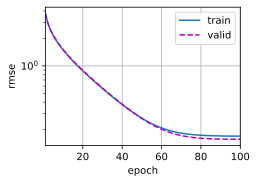

In [17]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

提交Kaggle预测

训练log rmse：0.162436


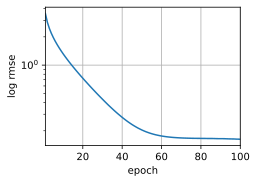

In [18]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    # 使用训练数据进行训练，并获取训练过程中的损失值  
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    # 绘制训练过程中的损失曲线（这里假设d2l是一个包含绘图函数的模块）  
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    
    # 使用训练好的模型对测试数据进行预测  
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)